<a href="https://colab.research.google.com/github/sangbartika-saha/Credit-Card_Fraudulent/blob/main/Copy_of_FINALWetland_Classification_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix


In [ ]:
# Wetland code mapping
wetland_code = [
    {'WETTCODE':1101,'WETLAND':"Lakes"},
    {'WETTCODE':1102,'WETLAND':"Ox-Bow Lakes  Cut - Off Meanders"},
    {'WETTCODE':1103,'WETLAND':"High Altitude Wetlands"},
    {'WETTCODE':1104,'WETLAND':"Riverine Wetlands"},
    {'WETTCODE':1105,'WETLAND':"Waterlogged"},
    {'WETTCODE':1106,'WETLAND':"River Stream"},
    {'WETTCODE':1201,'WETLAND':"Reservoirs or Barrages"},
    {'WETTCODE':1202,'WETLAND':"Tanks or Ponds"},
    {'WETTCODE':1203,'WETLAND':"Waterlogged"},
    {'WETTCODE':1204,'WETLAND':"Salt Pans in Inland "},
    {'WETTCODE':1205,'WETLAND':"Aquaculture ponds in Inland"},
    {'WETTCODE':2101,'WETLAND':"Lagoons"},
    {'WETTCODE':2102,'WETLAND':"Creeks"},
    {'WETTCODE':2103,'WETLAND':"Sand or Beach"},
    {'WETTCODE':2104,'WETLAND':"Intertidal mud flats"},
    {'WETTCODE':2105,'WETLAND':"Salt Marsh"},
    {'WETTCODE':2106,'WETLAND':"Mangroves"},
    {'WETTCODE':2107,'WETLAND':"Coral Reefs"},
    {'WETTCODE':2201,'WETLAND':"Salt Pans in Coastal"},
    {'WETTCODE':2202,'WETLAND':"Aquaculture ponds in Coastal"}
]

wetland_df = pd.DataFrame(wetland_code)


In [ ]:
# Load and merge the datasets
data_2006_07 = pd.read_csv('/content/drive/MyDrive/Final_point__CSV_06_07.csv')
data_2006_07 = data_2006_07.merge(wetland_df, on=['WETTCODE'], how='left', indicator=True)


In [ ]:
data_2006_07

,OBJECTID,Join_Count,TARGET_FID,pointid,grid_code,WETTCODE,WETNAME,AQVEG,TURBIDITY,AREAHA,WETCODE,STATUS1718,REMARKS,OBJECTID_1,UP_STATUS,X_Coord,Y_Coord,WETLAND,_merge
0,1,1,1,1,78,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,1,,9.845326e+05,1.047130e+06,River Stream,both
1,2,1,2,2,73,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,2,,9.845566e+05,1.047130e+06,River Stream,both
2,3,1,3,3,73,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,3,,9.845806e+05,1.047130e+06,River Stream,both
3,4,1,4,4,73,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,4,,9.846046e+05,1.047130e+06,River Stream,both
4,5,1,5,5,80,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,5,,9.846286e+05,1.047130e+06,River Stream,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380430,380431,1,380431,380431,135,2103,,N,NaN,3.955590,300200481001010,Y-Y,,380431,,1.008965e+06,9.480345e+05,Sand or Beach,both
380431,380432,1,380432,380432,119,2103,,N,NaN,3.955590,300200481001010,Y-Y,,380432,,1.008965e+06,9.480105e+05,Sand or Beach,both
380432,380433,1,380433,380433,120,2103,,N,NaN,3.955590,300200481001010,Y-Y,,380433,,1.008989e+06,9.480105e+05,Sand or Beach,both
380433,380434,1,380434,380434,91,2103,,N,NaN,3.955590,300200481001010,Y-Y,,380434,,1.008965e+06,9.479865e+05,Sand or Beach,both


In [ ]:
features = ['OBJECTID', 'Join_Count', 'TARGET_FID', 'pointid', 'grid_code', 'WETCODE', 'WETTCODE', 'WETNAME', 'AQVEG', 'TURBIDITY', 'AREAHA', 'STATUS1718', 'UP_STATUS', 'REMARKS', 'OBJECTID_1', 'X_Coord', 'Y_Coord']
label = 'WETLAND'

X_2006_07 = data_2006_07[features]
y_2006_07 = data_2006_07[label]

In [ ]:
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_2006_07, y_2006_07, test_size=0.2, random_state=42)


In [ ]:
# Define preprocessing for numerical and categorical data
numeric_features = ['WETTCODE', 'AREAHA', 'X_Coord', 'Y_Coord']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['TURBIDITY', 'AQVEG']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the pipeline with XGBoost classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])


In [ ]:
label_encoder = LabelEncoder()
y_train_subset_encoded = label_encoder.fit_transform(y_train_subset)


In [ ]:
# Train the model on the subset
start_time = time.time()
pipeline.fit(X_train_subset, y_train_subset_encoded)
end_time = time.time()


In [ ]:
# Encode test set labels
y_test_encoded = label_encoder.transform(y_test)

# Evaluate the model on the test set
test_accuracy = pipeline.score(X_test, y_test_encoded)


Train shapes: X_train_subset: (500, 17), y_train_subset_encoded: (500,)
Test shapes: X_test: (76087, 17), y_test_encoded: (76087,)
Unique classes in y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10]
Test Set Accuracy: 0.9988960006308568
Precision: 0.9990570780322426, Recall: 0.9578101456554495, F1-score: 0.972057894963336


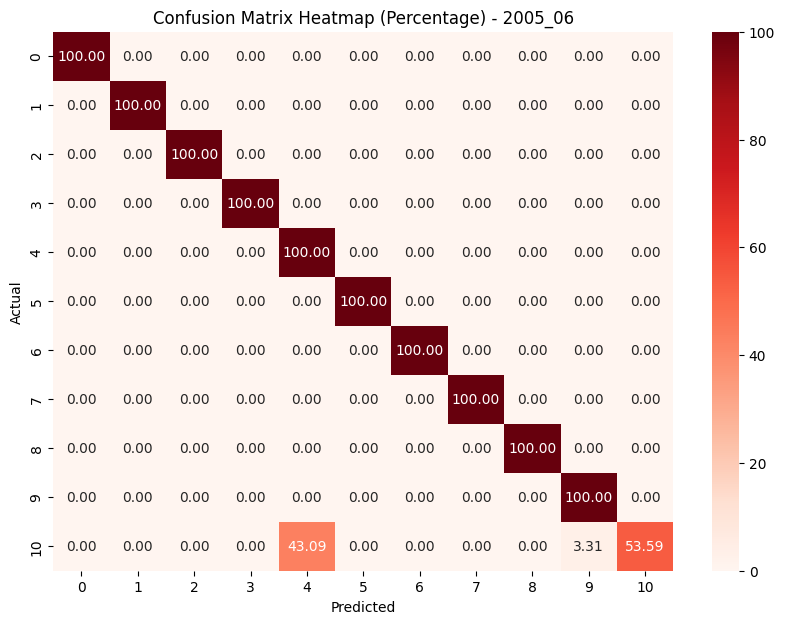

In [ ]:
# Assuming you have trained your pipeline on the subset and imported necessary libraries

# Ensure label encoding consistency
label_encoder = LabelEncoder()
y_train_subset_encoded = label_encoder.fit_transform(y_train_subset)
y_test_encoded = label_encoder.transform(y_test)

# Check shapes and labels
print(f'Train shapes: X_train_subset: {X_train_subset.shape}, y_train_subset_encoded: {y_train_subset_encoded.shape}')
print(f'Test shapes: X_test: {X_test.shape}, y_test_encoded: {y_test_encoded.shape}')
print(f'Unique classes in y_test_encoded: {np.unique(y_test_encoded)}')

# Make predictions on the test data
y_pred_test = pipeline.predict(X_test)

# Calculate accuracy for test data
accuracy_test = accuracy_score(y_test_encoded, y_pred_test)
print(f'Test Set Accuracy: {accuracy_test}')

# Evaluate on other metrics if needed (precision, recall, f1-score)
precision_test = precision_score(y_test_encoded, y_pred_test, average='macro')
recall_test = recall_score(y_test_encoded, y_pred_test, average='macro')
f1_test = f1_score(y_test_encoded, y_pred_test, average='macro')
print(f'Precision: {precision_test}, Recall: {recall_test}, F1-score: {f1_test}')

# Confusion matrix for test data
cm_test = confusion_matrix(y_test_encoded, y_pred_test)
cm_normalized_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
cm_percentage_test = cm_normalized_test * 100

plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage_test, annot=True, fmt='.2f', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap (Percentage) - 2005_06')
plt.show()


In [ ]:
# Save the model
model_path = 'best_model_pipeline_xgb.joblib'
joblib.dump(pipeline, model_path)


['best_model_pipeline_xgb.joblib']

In [ ]:
print(f"Training time: {end_time - start_time} seconds")
print(f"Model pipeline saved to {model_path}")


Training time: 1.3462131023406982 seconds
Model pipeline saved to best_model_pipeline_xgb.joblib


In [ ]:
# Make predictions on the test data
y_pred = pipeline.predict(X_test)


In [ ]:
# Calculate accuracy, precision, recall, and f1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


ValueError: Mix of label input types (string and number)

In [ ]:
print(f'Accuracy 2007 : {accuracy}')
print(f'Precision 2007: {precision}')
print(f'Recall 2007: {recall}')
print(f'F1-score 2007: {f1}')

Accuracy 2007 : 1.0
Precision 2007: 1.0
Recall 2007: 1.0
F1-score 2007: 1.0


In [ ]:
# Plotting metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [accuracy, precision, recall, f1]


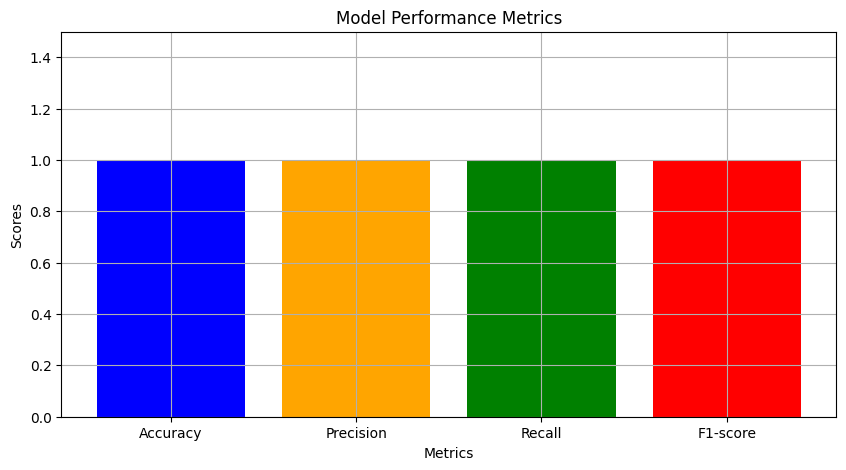

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(metrics, scores, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1.5)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.grid(True)
plt.show()

Training Accuracy: 1.0
Testing Accuracy: 1.0


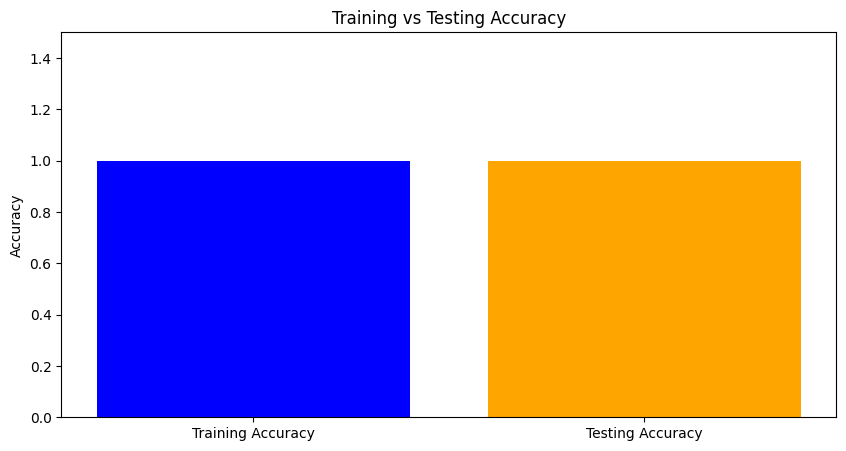

In [ ]:
# Evaluate the model
train_accuracy = best_pipeline.score(X_train, y_train)
test_accuracy = best_pipeline.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

plt.figure(figsize=(10, 5))
labels = ['Training Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, test_accuracy]

plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1.5)
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.show()


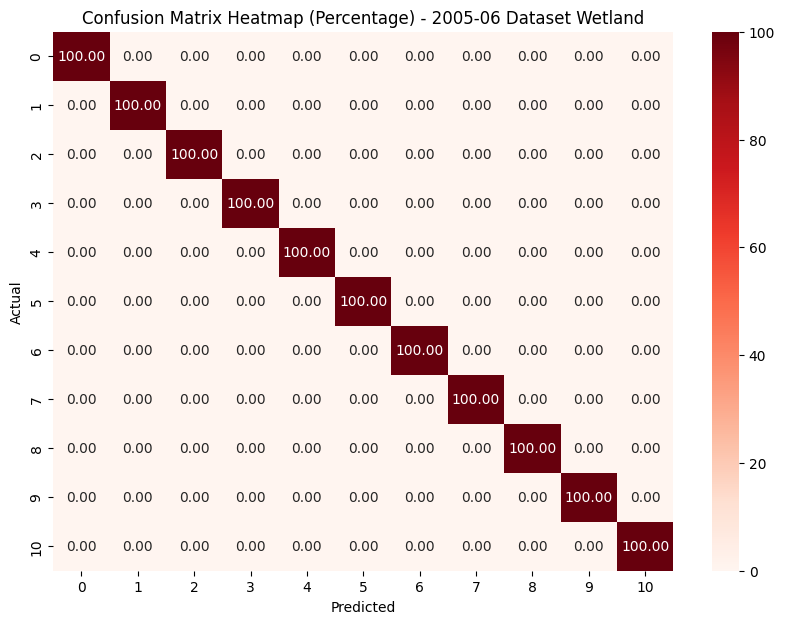

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percentage = cm_normalized * 100

plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap (Percentage) - 2005-06 Dataset Wetland')
plt.show()


In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


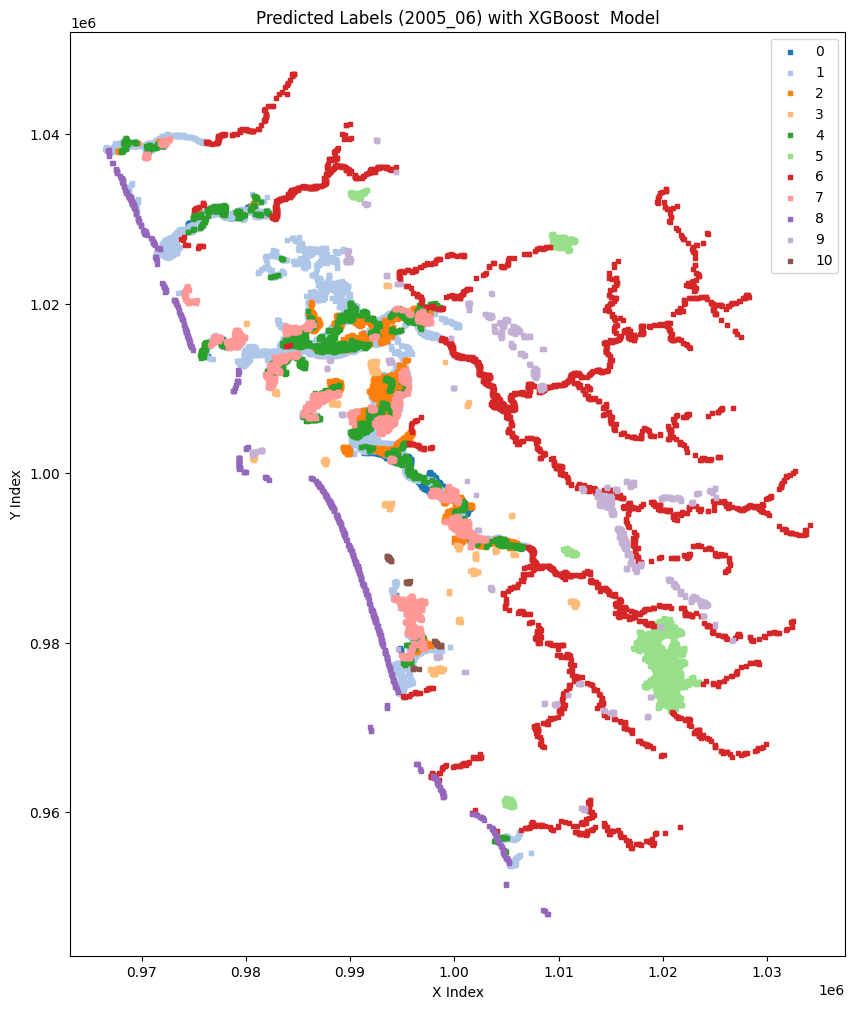

In [ ]:
wetland_code = {
    1101: "Lakes",
    1102: "Ox-Bow Lakes Cut - Off Meanders",
    1103: "High Altitude Wetlands",
    1104: "Riverine Wetlands",
    1105: "Waterlogged",
    1106: "River Stream",
    1201: "Reservoirs or Barrages",
    1202: "Tanks or Ponds",
    1203: "Waterlogged",
    1204: "Salt Pans in Inland",
    1205: "Aquaculture ponds in Inland",
    2101: "Lagoons",
    2102: "Creeks",
    2103: "Sand or Beach",
    2104: "Intertidal mud flats",
    2105: "Salt Marsh",
    2106: "Mangroves",
    2107: "Coral Reefs",
    2201: "Salt Pans in Coastal",
    2202: "Aquaculture ponds in Coastal"
}
# Plotting using only X_test and corresponding coordinates from data_2017_18
X_test_coords = data_2006_07.loc[X_test.index, ['X_Coord', 'Y_Coord']]

# Create a list of unique wettcodes
unique_wettcodes = np.unique(y_pred)

# Create a colormap with enough colors
num_colors = len(unique_wettcodes)
colors = plt.cm.tab20.colors[:num_colors]  # Using tab20 colormap for up to 20 different colors

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Scatter plot for predicted labels with wetland names
for i, wettcode in enumerate(unique_wettcodes):
    # Filter data for the current wettcode
    mask = y_pred == wettcode
    label = f"{wettcode}"
    #- {wetland_code.get(wettcode, 'Unknown')}
    ax.scatter(X_test_coords.loc[mask, 'X_Coord'], X_test_coords.loc[mask, 'Y_Coord'], label=label, color=colors[i], marker='s', s=10)


# Add legend
ax.legend()
# Set plot title and labels
ax.set_title('Predicted Labels (2005_06) with XGBoost  Model')
ax.set_xlabel('X Index')
ax.set_ylabel('Y Index')

fig.savefig('predicted_labels_2006_07_SAT.jpeg', format='jpeg', dpi=300)


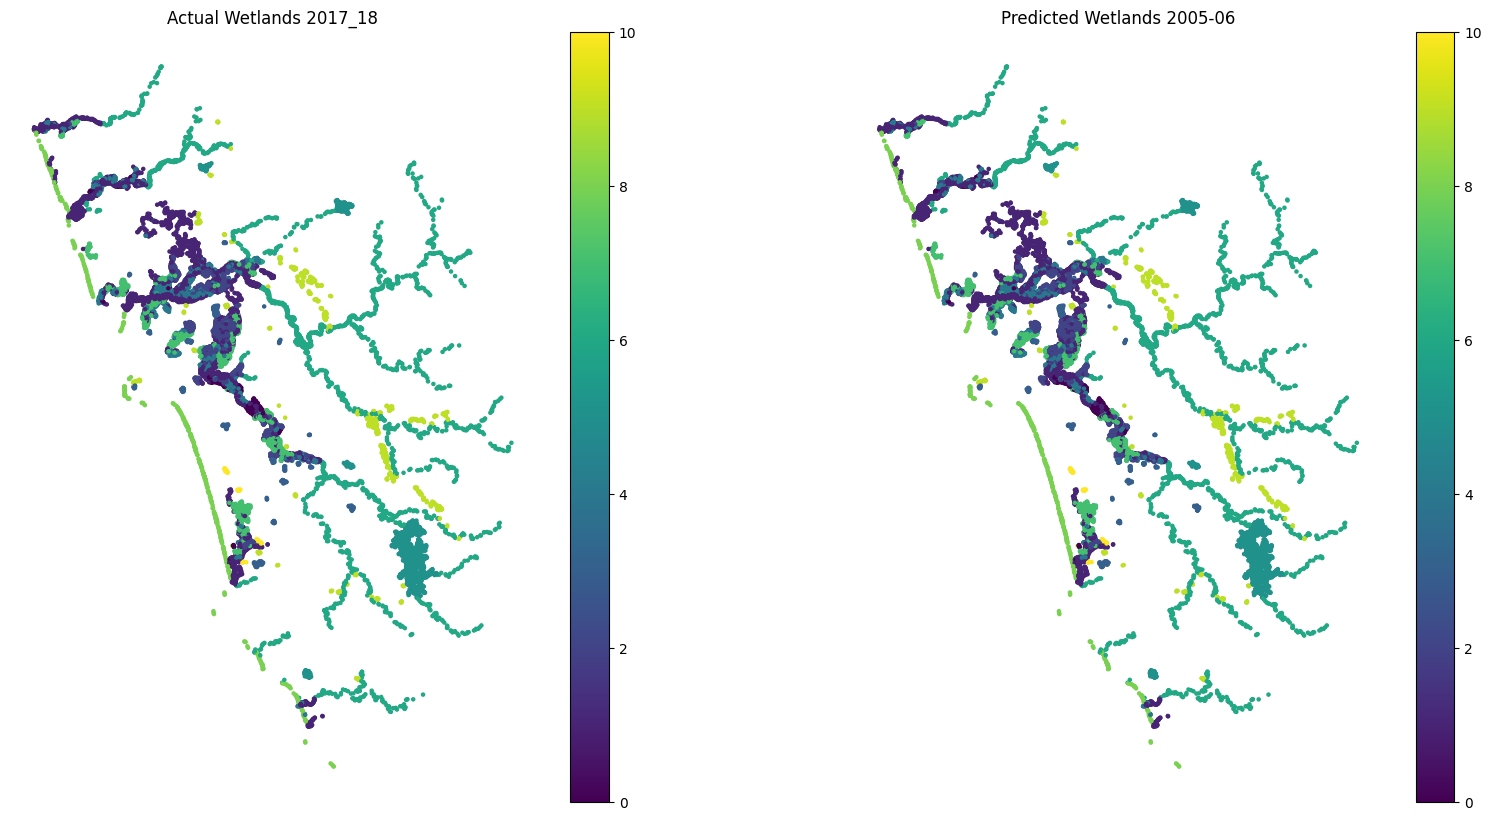

In [ ]:
# Import necessary libraries
import geopandas as gpd
from shapely.geometry import Point

# Convert the test set and predictions to a GeoDataFrame
X_test['predicted_wetland'] = y_pred
X_test['actual_wetland'] = y_test

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(X_test['X_Coord'], X_test['Y_Coord'])]
gdf = gpd.GeoDataFrame(X_test, geometry=geometry)

# Plot the actual wetlands
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
gdf.plot(ax=ax[0], column='actual_wetland', cmap='viridis', legend=True, markersize=5)
ax[0].set_title('Actual Wetlands 2005_06')
ax[0].set_axis_off()

# Plot the predicted wetlands
gdf.plot(ax=ax[1], column='predicted_wetland', cmap='viridis', legend=True, markersize=5)
ax[1].set_title('Predicted Wetlands 2005-06')
ax[1].set_axis_off()

plt.show()


Prediction with 2017-18 dataset

In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
# Load and process the 2017-18 dataset
new_data = pd.read_csv('/content/drive/MyDrive/FINAL_DATA_SATELLITE IMAGE/FINAL_DATA_SATELLITE IMAGE/Final_poin_CSV_17_18.csv')
new_data = new_data.merge(wetland_df, on=['WETTCODE'], how='left', indicator=True)


<ipython-input-89-e091a5921418>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  new_data = pd.read_csv('/content/drive/MyDrive/FINAL_DATA_SATELLITE IMAGE/FINAL_DATA_SATELLITE IMAGE/Final_poin_CSV_17_18.csv')


In [ ]:
new_data.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'pointid', 'grid_code',
       'WETCODE', 'WETTCODE', 'WETNAME', 'AQVEG', 'TURBIDITY', 'AREAHA',
       'STATUS1718', 'UP_STATUS', 'REMARKS', 'OBJECTID_1', 'X_Coord',
       'Y_Coord', 'WETLAND_x', 'WETLAND_y', '_merge'],
      dtype='object')

In [ ]:
new_data = new_data.drop(columns=['WETLAND_x'])
features = ['OBJECTID', 'Join_Count', 'TARGET_FID', 'pointid', 'grid_code',
       'WETCODE', 'WETTCODE', 'WETNAME', 'AQVEG', 'TURBIDITY', 'AREAHA',
       'STATUS1718', 'UP_STATUS', 'REMARKS', 'OBJECTID_1', 'X_Coord',
       'Y_Coord']

label=['WETLAND_y']
X_2017_18 = new_data[features]
y_2017_18 = new_data[label]

In [ ]:
# Encode the labels for the new dataset
y_2017_18_encoded = label_encoder.transform(y_2017_18)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# Train and evaluate on the 2017-18 dataset
X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_split(X_2017_18, y_2017_18_encoded, test_size=0.2, random_state=42, stratify=y_2017_18_encoded)


In [ ]:
# Define preprocessing for numerical and categorical data
numeric_features = ['WETTCODE', 'AREAHA', 'X_Coord', 'Y_Coord']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['TURBIDITY', 'AQVEG']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the pipeline with XGBoost classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])


In [ ]:
# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__reg_alpha': [0, 0.1],  # L1 regularization
    'classifier__reg_lambda': [1, 10]  # L2 regularization
}

In [ ]:
# Fit the model
best_pipeline.fit(X_train_2017, y_train_2017)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['WETTCODE', 'AREAHA',
                                                   'X_Coord', 'Y_Coord']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TURBIDITY', 'AQVE...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [ ]:
# Predict on the test set
y_pred_2017 = best_pipeline.predict(X_test_2017)


In [ ]:
# Calculate and print metrics
accuracy_2017 = accuracy_score(y_test_2017, y_pred_2017)
precision_2017 = precision_score(y_test_2017, y_pred_2017, average='macro')
recall_2017 = recall_score(y_test_2017, y_pred_2017, average='macro')
f1_2017 = f1_score(y_test_2017, y_pred_2017, average='macro')


In [ ]:
print(f'Accuracy 2017-18: {accuracy_2017}')
print(f'Precision 2017-18: {precision_2017}')
print(f'Recall 2017-18: {recall_2017}')
print(f'F1-score 2017-18: {f1_2017}')


Accuracy 2017-18: 1.0
Precision 2017-18: 1.0
Recall 2017-18: 1.0
F1-score 2017-18: 1.0


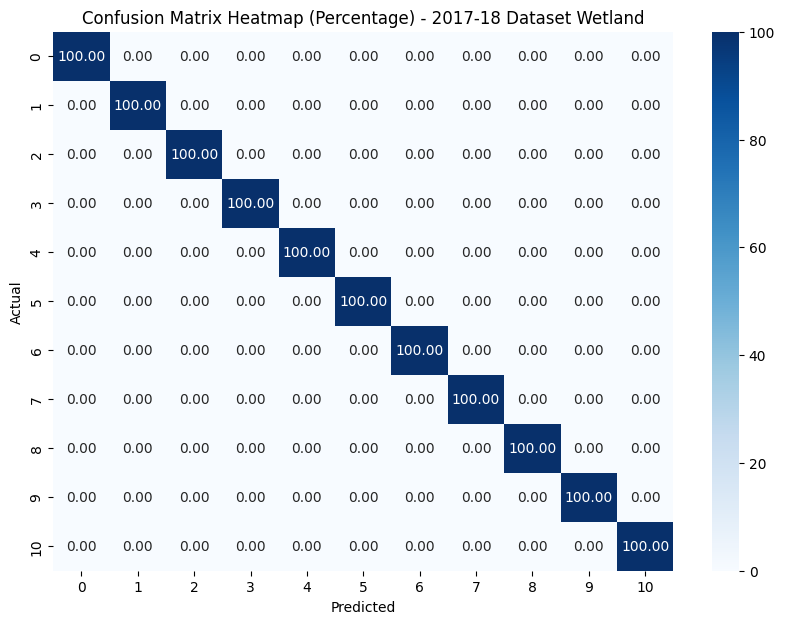

In [ ]:
# Confusion matrix for 2017-18
cm_2017 = confusion_matrix(y_test_2017, y_pred_2017)
cm_normalized_2017 = cm_2017.astype('float') / cm_2017.sum(axis=1)[:, np.newaxis]
cm_percentage_2017 = cm_normalized_2017 * 100

plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage_2017, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap (Percentage) - 2017-18 Dataset Wetland')
plt.show()

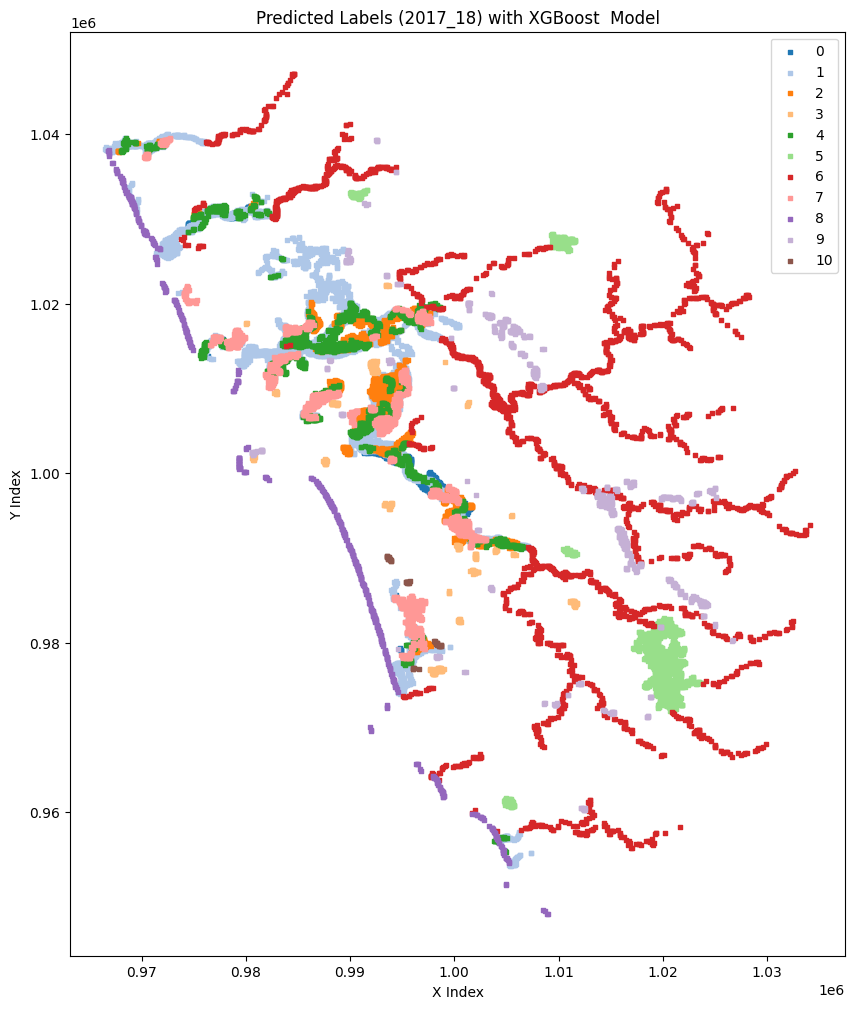

In [ ]:
wetland_code = {
    1101: "Lakes",
    1102: "Ox-Bow Lakes Cut - Off Meanders",
    1103: "High Altitude Wetlands",
    1104: "Riverine Wetlands",
    1105: "Waterlogged",
    1106: "River Stream",
    1201: "Reservoirs or Barrages",
    1202: "Tanks or Ponds",
    1203: "Waterlogged",
    1204: "Salt Pans in Inland",
    1205: "Aquaculture ponds in Inland",
    2101: "Lagoons",
    2102: "Creeks",
    2103: "Sand or Beach",
    2104: "Intertidal mud flats",
    2105: "Salt Marsh",
    2106: "Mangroves",
    2107: "Coral Reefs",
    2201: "Salt Pans in Coastal",
    2202: "Aquaculture ponds in Coastal"
}
# Plotting using only X_test and corresponding coordinates from data_2017_18
X_test_coords = data_2006_07.loc[X_test.index, ['X_Coord', 'Y_Coord']]

# Create a list of unique wettcodes
unique_wettcodes = np.unique(y_pred)

# Create a colormap with enough colors
num_colors = len(unique_wettcodes)
colors = plt.cm.tab20.colors[:num_colors]  # Using tab20 colormap for up to 20 different colors

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Scatter plot for predicted labels with wetland names
for i, wettcode in enumerate(unique_wettcodes):
    # Filter data for the current wettcode
    mask = y_pred == wettcode
    label = f"{wettcode}"
    #- {wetland_code.get(wettcode, 'Unknown')}
    ax.scatter(X_test_coords.loc[mask, 'X_Coord'], X_test_coords.loc[mask, 'Y_Coord'], label=label, color=colors[i], marker='s', s=10)


# Add legend
ax.legend()
# Set plot title and labels
ax.set_title('Predicted Labels (2017_18) with XGBoost  Model')
ax.set_xlabel('X Index')
ax.set_ylabel('Y Index')

fig.savefig('predicted_labels_2017_18_SAT.jpeg', format='jpeg', dpi=300)


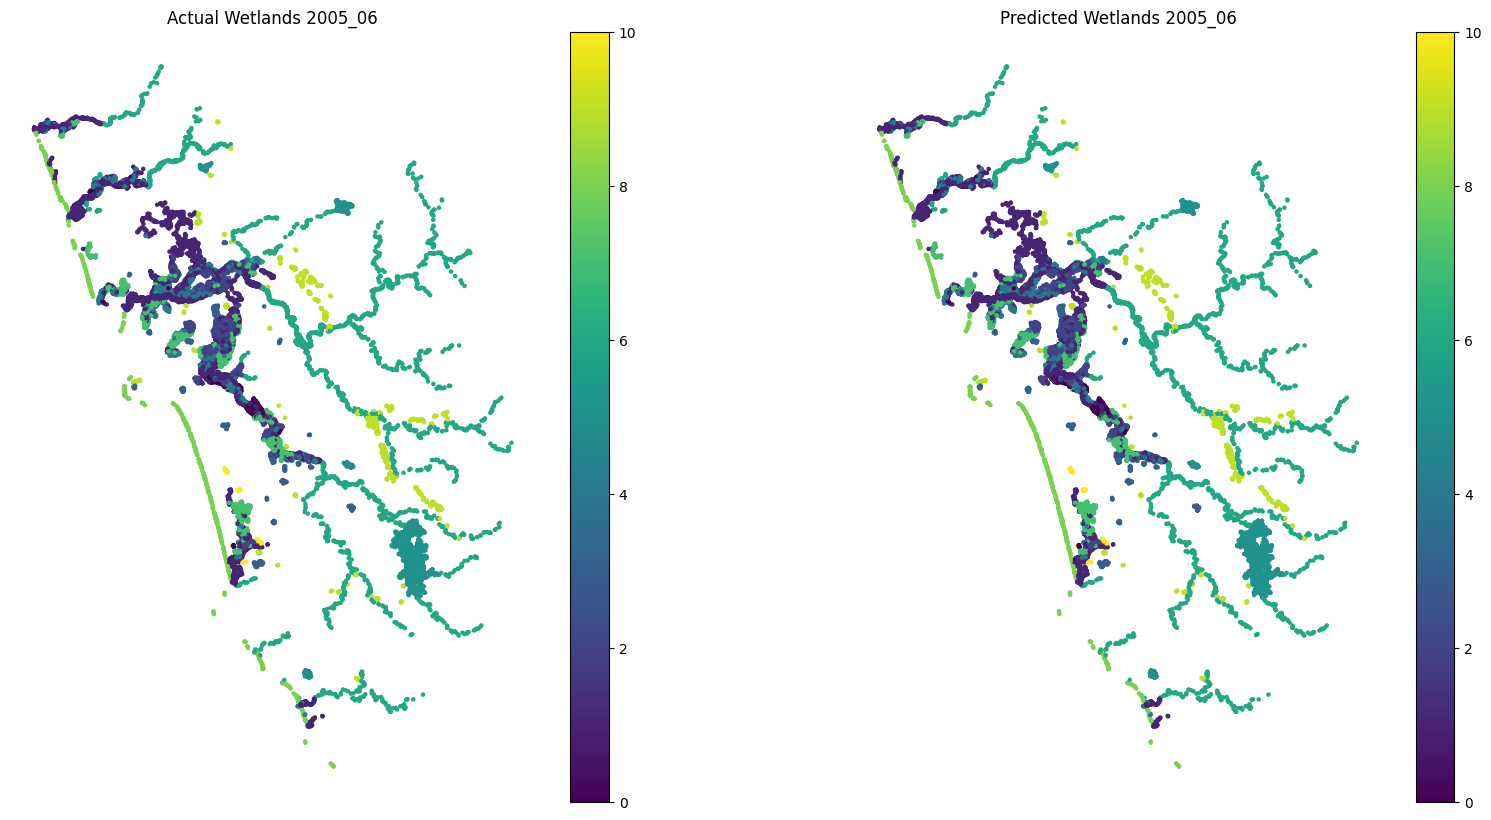

In [ ]:
# Import necessary libraries
import geopandas as gpd
from shapely.geometry import Point

# Convert the test set and predictions to a GeoDataFrame
X_test['predicted_wetland'] = y_pred
X_test['actual_wetland'] = y_test

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(X_test['X_Coord'], X_test['Y_Coord'])]
gdf = gpd.GeoDataFrame(X_test, geometry=geometry)

# Plot the actual wetlands
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
gdf.plot(ax=ax[0], column='actual_wetland', cmap='viridis', legend=True, markersize=5)
ax[0].set_title('Actual Wetlands 2005_06')
ax[0].set_axis_off()

# Plot the predicted wetlands
gdf.plot(ax=ax[1], column='predicted_wetland', cmap='viridis', legend=True, markersize=5)
ax[1].set_title('Predicted Wetlands 2005_06')
ax[1].set_axis_off()

plt.show()


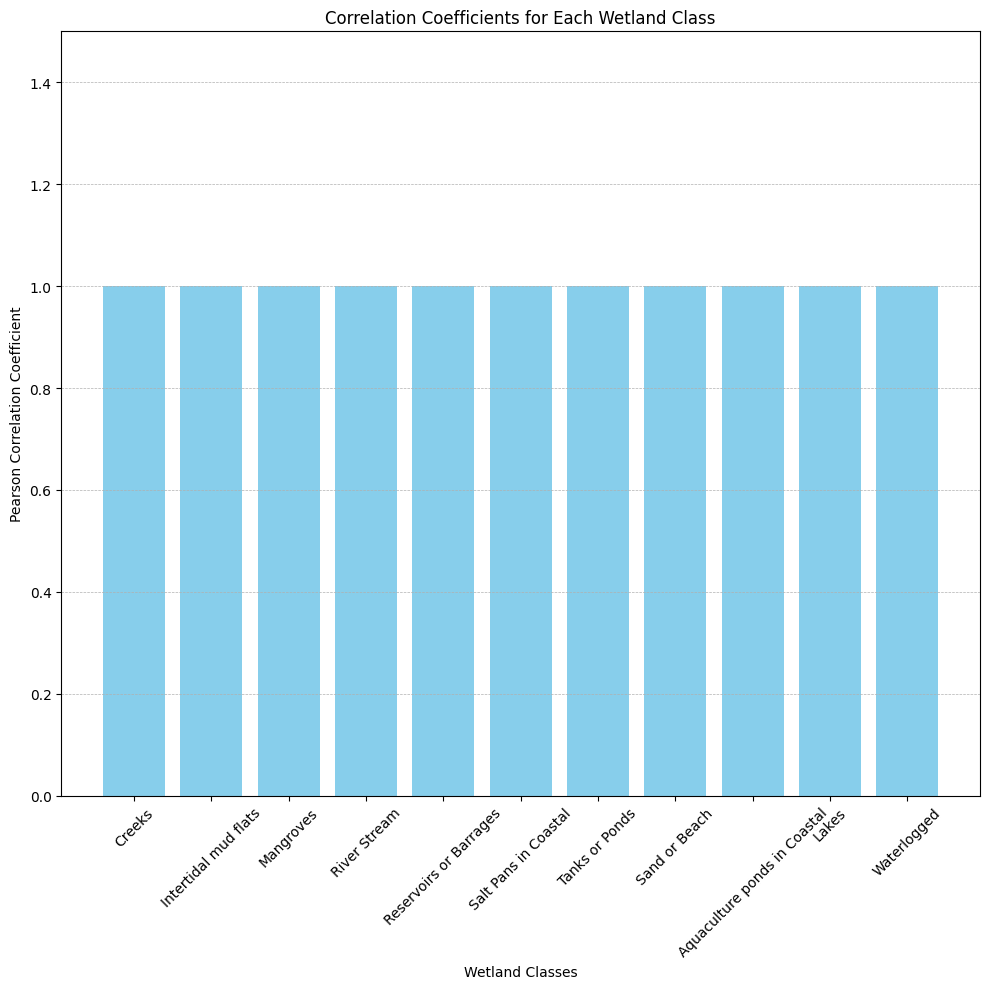

In [ ]:
def pearson_correlation(cm, cm_2017):
    corr_coeffs = []
    for i in range(len(cm)):
        corr_coeff = np.corrcoef(cm[i], cm_2017[i])[0, 1]
        corr_coeffs.append(corr_coeff)
    return corr_coeffs

# Compute correlation coefficients for each wetland class
correlation_coefficients = pearson_correlation(cm, cm_2017)

# Wetland class labels (replace with your actual labels)
wetland_classes = ['Creeks', 'Intertidal mud flats', 'Mangroves', 'River Stream', 'Reservoirs or Barrages', 'Salt Pans in Coastal', 'Tanks or Ponds', 'Sand or Beach', 'Aquaculture ponds in Coastal', 'Lakes', 'Waterlogged']

# Plotting correlation coefficients
plt.figure(figsize=(10, 10))
plt.bar(wetland_classes, correlation_coefficients, color='skyblue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)  # Add horizontal line at y=0 for reference
plt.xlabel('Wetland Classes')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Correlation Coefficients for Each Wetland Class')
plt.ylim(0, 1.5)  # Set y-axis limits from -1 to 1 for correlation coefficients
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

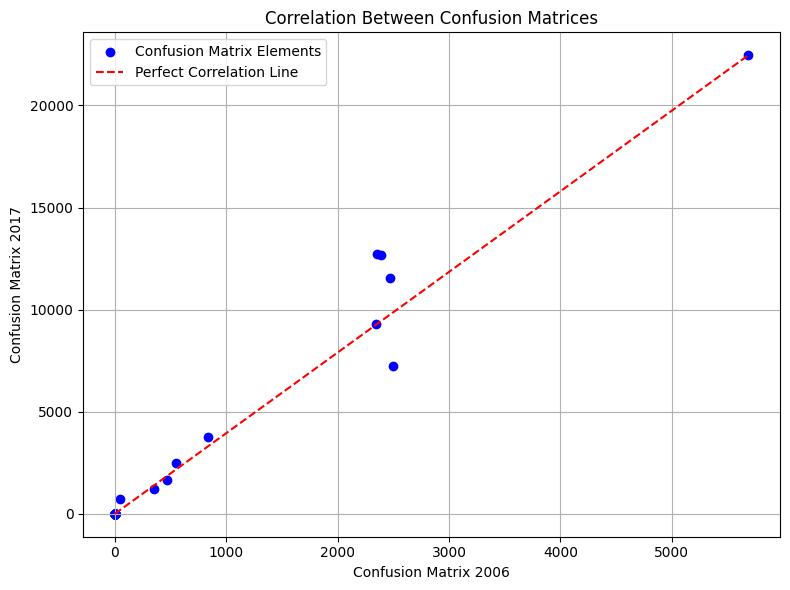

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Flatten the confusion matrices
flat_cm_2006 = cm.flatten()
flat_cm_2017 = cm_2017.flatten()

# Create a scatter plot to compare the confusion matrices
plt.figure(figsize=(8, 6))
plt.scatter(flat_cm_2006, flat_cm_2017, color='blue', marker='o', label='Confusion Matrix Elements')
plt.plot([0, np.max(flat_cm_2006)], [0, np.max(flat_cm_2017)], color='red', linestyle='--', label='Perfect Correlation Line')
plt.xlabel('Confusion Matrix 2006')
plt.ylabel('Confusion Matrix 2017')
plt.title('Correlation Between Confusion Matrices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


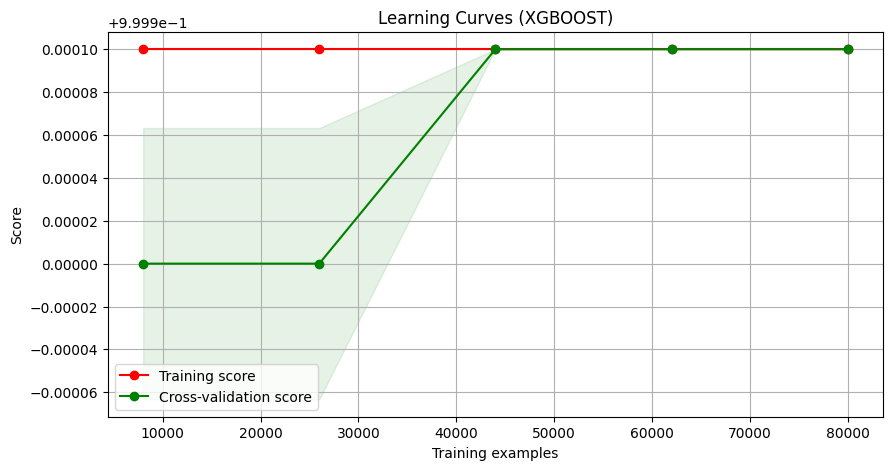

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
# Plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r"
    )
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g"
    )
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for the best estimator
plot_learning_curve(pipeline, "Learning Curves (XGBOOST)", X_train_subset, y_train_subset, cv=5)
plt.show()


Area Difference Between 2006-07 and 2017-18 Datasets

In [ ]:
import pandas as pd

In [ ]:
# Load the datasets if not already loaded
data_2006_07 = pd.read_csv('/content/drive/MyDrive/Final_point__CSV_06_07.csv')
data_2017_18 = pd.read_csv('/content/drive/MyDrive/FINAL_DATA_SATELLITE IMAGE/FINAL_DATA_SATELLITE IMAGE/Final_poin_CSV_17_18.csv')

# Ensure both datasets have the necessary columns
assert 'AREAHA' in data_2006_07.columns, "AREAHA column is missing in 2006-07 dataset"
assert 'AREAHA' in data_2017_18.columns, "AREAHA column is missing in 2017-18 dataset"



<ipython-input-6-57463d4ab03d>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2017_18 = pd.read_csv('/content/drive/MyDrive/FINAL_DATA_SATELLITE IMAGE/FINAL_DATA_SATELLITE IMAGE/Final_poin_CSV_17_18.csv')


In [ ]:
# Merge datasets on a common key (adjust as necessary based on your data)
merged_data = pd.merge(data_2006_07, data_2017_18, on='OBJECTID', suffixes=('_2006_07', '_2017_18'))


In [ ]:
# Calculate the difference in area
merged_data['AREA_DIFF'] = merged_data['AREAHA_2017_18'] - merged_data['AREAHA_2006_07']


In [ ]:
# Summarize the differences
total_area_diff = merged_data['AREA_DIFF'].sum()
mean_area_diff = merged_data['AREA_DIFF'].mean()
max_area_diff = merged_data['AREA_DIFF'].max()
min_area_diff = merged_data['AREA_DIFF'].min()


In [ ]:
print(f"Total difference in area: {total_area_diff} hectares")
print(f"Average difference in area: {mean_area_diff} hectares")
print(f"Maximum increase in area: {max_area_diff} hectares")
print(f"Maximum decrease in area: {min_area_diff} hectares")


Total difference in area: -38732892.211918674 hectares
Average difference in area: -101.81211563583445 hectares
Maximum increase in area: 2216.1001550873198 hectares
Maximum decrease in area: -2438.08036551963 hectares


In [ ]:
import matplotlib.pyplot as plt
frome sea
# Plot the distribution of area differences
plt.figure(figsize=(10, 5))
sns.histplot(merged_data['AREA_DIFF'], kde=True)
plt.xlabel('Difference in Area (hectares)')
plt.ylabel('Frequency')
plt.title('Distribution of Area Differences between 2005-06 and 2017-18')
plt.grid(True)
plt.show()


NameError: name 'sns' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Display the first few rows to verify
print(merged_data[['OBJECTID', 'AREAHA_2006_07', 'AREAHA_2017_18', 'AREA_DIFF']].head())

   OBJECTID  AREAHA_2006_07  AREAHA_2017_18  AREA_DIFF
0         1      126.900842      133.210707   6.309864
1         2      126.900842      133.210707   6.309864
2         3      126.900842      133.210707   6.309864
3         4      126.900842      133.210707   6.309864
4         5      126.900842      133.210707   6.309864


In [ ]:
import pandas as  pd
# Load the datasets if not already loaded
data_2006_07 = pd.read_csv('/content/drive/MyDrive/Final_point__CSV_06_07.csv')
data_2017_18 = pd.read_csv('/content/drive/MyDrive/FINAL_DATA_SATELLITE IMAGE/FINAL_DATA_SATELLITE IMAGE/Final_poin_CSV_17_18.csv')


<ipython-input-14-f6f9d580e3ae>:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2017_18 = pd.read_csv('/content/drive/MyDrive/FINAL_DATA_SATELLITE IMAGE/FINAL_DATA_SATELLITE IMAGE/Final_poin_CSV_17_18.csv')


In [ ]:
# Wetland code mapping
wetland_code = [
    {'WETTCODE':1101,'WETLAND':"Lakes"},
    {'WETTCODE':1102,'WETLAND':"Ox-Bow Lakes  Cut - Off Meanders"},
    {'WETTCODE':1103,'WETLAND':"High Altitude Wetlands"},
    {'WETTCODE':1104,'WETLAND':"Riverine Wetlands"},
    {'WETTCODE':1105,'WETLAND':"Waterlogged"},
    {'WETTCODE':1106,'WETLAND':"River Stream"},
    {'WETTCODE':1201,'WETLAND':"Reservoirs or Barrages"},
    {'WETTCODE':1202,'WETLAND':"Tanks or Ponds"},
    {'WETTCODE':1203,'WETLAND':"Waterlogged"},
    {'WETTCODE':1204,'WETLAND':"Salt Pans in Inland "},
    {'WETTCODE':1205,'WETLAND':"Aquaculture ponds in Inland"},
    {'WETTCODE':2101,'WETLAND':"Lagoons"},
    {'WETTCODE':2102,'WETLAND':"Creeks"},
    {'WETTCODE':2103,'WETLAND':"Sand or Beach"},
    {'WETTCODE':2104,'WETLAND':"Intertidal mud flats"},
    {'WETTCODE':2105,'WETLAND':"Salt Marsh"},
    {'WETTCODE':2106,'WETLAND':"Mangroves"},
    {'WETTCODE':2107,'WETLAND':"Coral Reefs"},
    {'WETTCODE':2201,'WETLAND':"Salt Pans in Coastal"},
    {'WETTCODE':2202,'WETLAND':"Aquaculture ponds in Coastal"}
]

wetland_df = pd.DataFrame(wetland_code)


In [ ]:
data_2017_18

,OBJECTID,Join_Count,TARGET_FID,pointid,grid_code,WETCODE,WETTCODE,WETNAME,AQVEG,TURBIDITY,AREAHA,STATUS1718,UP_STATUS,REMARKS,OBJECTID_1,X_Coord,Y_Coord,WETLAND
0,1,1,1,1,13091,279999999999999,1106,Terekhol River,N,L,133.210707,Y-Y,YY,,1,377318.422808,1.747078e+06,NaN
1,2,1,2,2,16389,279999999999999,1106,Terekhol River,N,L,133.210707,Y-Y,YY,,2,377294.417996,1.747054e+06,NaN
2,3,1,3,3,11251,279999999999999,1106,Terekhol River,N,L,133.210707,Y-Y,YY,,3,377318.422808,1.747054e+06,NaN
3,4,1,4,4,13091,279999999999999,1106,Terekhol River,N,L,133.210707,Y-Y,YY,,4,377270.413184,1.747030e+06,NaN
4,5,1,5,5,16389,279999999999999,1106,Terekhol River,N,L,133.210707,Y-Y,YY,,5,377294.417996,1.747030e+06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428528,428529,1,428529,428529,164,300200481001010,2103,,N,NaN,5.339286,Y-Y,YY,,428529,401371.244432,1.648058e+06,NaN
428529,428530,1,428530,428530,128,300200481001010,2103,,N,NaN,5.339286,Y-Y,YY,,428530,401395.249244,1.648058e+06,NaN
428530,428531,1,428531,428531,3420,300200481001010,2103,,N,NaN,5.339286,Y-Y,YY,,428531,401419.254056,1.648058e+06,NaN
428531,428532,1,428532,428532,164,300200481001010,2103,,N,NaN,5.339286,Y-Y,YY,,428532,401395.249244,1.648034e+06,NaN


In [ ]:
#Merge Wetland Class column in 2007 dataset
data_2006_07 = data_2006_07.merge(wetland_df, on=['WETTCODE'], how='left', indicator=True)
#Merge Wetland Class column in 2007 dataset
data_2017_18= data_2017_18.merge(wetland_df, on=['WETTCODE'], how='left', indicator=True)


In [ ]:
data_2006_07.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'pointid', 'grid_code',
       'WETTCODE', 'WETNAME', 'AQVEG', 'TURBIDITY', 'AREAHA', 'WETCODE',
       'STATUS1718', 'REMARKS', 'OBJECTID_1', 'UP_STATUS', 'X_Coord',
       'Y_Coord', 'WETLAND', '_merge'],
      dtype='object')

In [ ]:
data_2017_18.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'pointid', 'grid_code',
       'WETCODE', 'WETTCODE', 'WETNAME', 'AQVEG', 'TURBIDITY', 'AREAHA',
       'STATUS1718', 'UP_STATUS', 'REMARKS', 'OBJECTID_1', 'X_Coord',
       'Y_Coord', 'WETLAND_x', 'WETLAND_y', '_merge'],
      dtype='object')

In [ ]:
data_2017_18=data_2017_18.drop(columns=['WETLAND_x'])
data_2017_18.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'pointid', 'grid_code',
       'WETCODE', 'WETTCODE', 'WETNAME', 'AQVEG', 'TURBIDITY', 'AREAHA',
       'STATUS1718', 'UP_STATUS', 'REMARKS', 'OBJECTID_1', 'X_Coord',
       'Y_Coord', 'WETLAND_y', '_merge'],
      dtype='object')

In [ ]:
data_2006_07

,OBJECTID,Join_Count,TARGET_FID,pointid,grid_code,WETTCODE,WETNAME,AQVEG,TURBIDITY,AREAHA,WETCODE,STATUS1718,REMARKS,OBJECTID_1,UP_STATUS,X_Coord,Y_Coord,WETLAND,_merge
0,1,1,1,1,78,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,1,,9.845326e+05,1.047130e+06,River Stream,both
1,2,1,2,2,73,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,2,,9.845566e+05,1.047130e+06,River Stream,both
2,3,1,3,3,73,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,3,,9.845806e+05,1.047130e+06,River Stream,both
3,4,1,4,4,73,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,4,,9.846046e+05,1.047130e+06,River Stream,both
4,5,1,5,5,80,1106,Terekhol River,N,L,126.900842,279999999999999,Y-Y,,5,,9.846286e+05,1.047130e+06,River Stream,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380430,380431,1,380431,380431,135,2103,,N,NaN,3.955590,300200481001010,Y-Y,,380431,,1.008965e+06,9.480345e+05,Sand or Beach,both
380431,380432,1,380432,380432,119,2103,,N,NaN,3.955590,300200481001010,Y-Y,,380432,,1.008965e+06,9.480105e+05,Sand or Beach,both
380432,380433,1,380433,380433,120,2103,,N,NaN,3.955590,300200481001010,Y-Y,,380433,,1.008989e+06,9.480105e+05,Sand or Beach,both
380433,380434,1,380434,380434,91,2103,,N,NaN,3.955590,300200481001010,Y-Y,,380434,,1.008965e+06,9.479865e+05,Sand or Beach,both


In [ ]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Assuming you have loaded your unseen data into X_test and corresponding labels into y_test

# Step 1: Load the model
model = joblib.load('best_model_pipeline_xgb.joblib')

# Step 2: Assuming X_test is your unseen data
# Replace this with your actual preparation of unseen data if needed
# X_test = prepare_unseen_data()

# Step 3: Predict
y_pred = model.predict(X_test_2017)

# Step 4: Evaluate
accuracy = accuracy_score(y_test_2017, y_pred)
precision = precision_score(y_test_2017, y_pred)
recall = recall_score(y_test_2017, y_pred)
f1 = f1_score(y_test_2017, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have loaded your unseen data into X_test_2017 and corresponding labels into y_test_2017

# Step 1: Load the model
model = joblib.load('best_model_pipeline_xgb.joblib')

# Step 2: Assuming X_test_2017 is your unseen data
# Replace this with your actual preparation of unseen data if needed
# X_test_2017 = prepare_unseen_data()

# Step 3: Predict
y_pred = model.predict(X_test_2017)

# Step 4: Evaluate
accuracy = accuracy_score(y_test_2017, y_pred)
precision = precision_score(y_test_2017, y_pred, average='weighted')  # Specify average='weighted' for multiclass
recall = recall_score(y_test_2017, y_pred, average='weighted')  # Specify average='weighted' for multiclass
f1 = f1_score(y_test_2017, y_pred, average='weighted')  # Specify average='weighted' for multiclass

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9935
Precision: 0.9935
Recall: 0.9935
F1 Score: 0.9931


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1636
           1       1.00      1.00      1.00     22459
           2       1.00      1.00      1.00     12730
           3       1.00      1.00      1.00      1231
           4       1.00      1.00      1.00     12698
           5       0.97      1.00      0.98      9280
           6       0.99      1.00      0.99     11540
           7       1.00      1.00      1.00      7218
           8       1.00      1.00      1.00      2470
           9       0.98      0.91      0.95      3740
          10       1.00      0.68      0.81       705

    accuracy                           0.99     85707
   macro avg       0.99      0.96      0.98     85707
weighted avg       0.99      0.99      0.99     85707



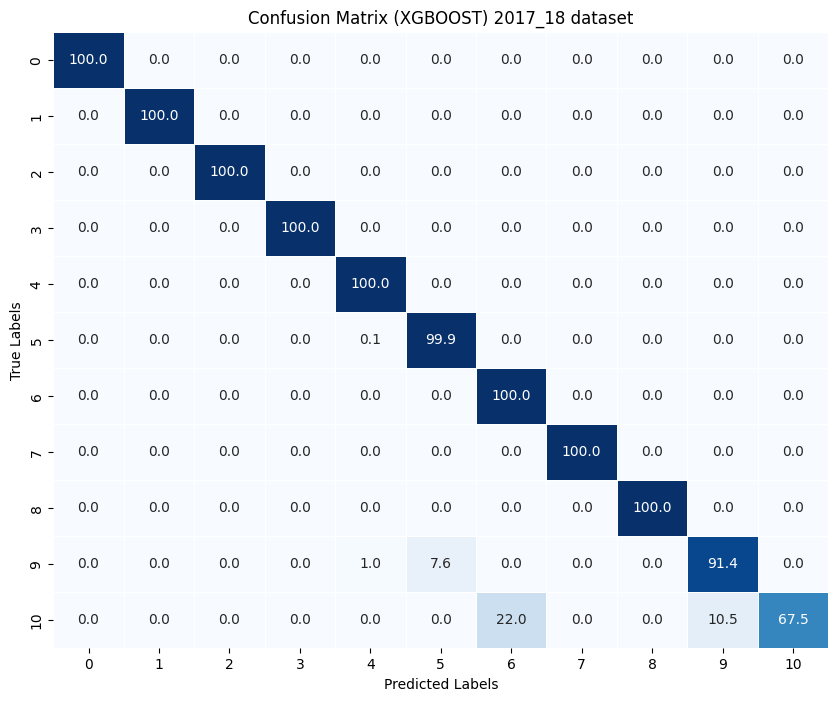

In [ ]:
# Step 5: Print classification report (optional)
print(classification_report(y_test_2017, y_pred))

# Step 6: Encode class labels if they are not numeric
# If your labels are not numeric, you may need to encode them for the confusion matrix plot
# Example:
# encoder = LabelEncoder()
# y_test_encoded = encoder.fit_transform(y_test_2017)
# y_pred_encoded = encoder.transform(y_pred)

# Step 7: Create confusion matrix
cm = confusion_matrix(y_test_2017, y_pred)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Step 8: Plot confusion matrix as heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', linewidths=.5, cbar=False)
plt.title('Confusion Matrix (XGBOOST) 2017_18 dataset')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()